In [19]:
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
from astropy.io import fits
import os
import glob
from scipy.optimize import curve_fit
import json
sys.path.insert(0, '../../operational_scripts')

from New_DRRP_Functions import dark_subtract, find_pixels, extract_intensities, q_ultimate_polarimetry, I_ultimate_polarimetry
# from New_DRRP_Functions import *

c:\Users\Willi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [1]:
# through stokes and exoserver
img_file = '/home/shared/exoserver/Lab_Data/Mueller_Matrix_Polarimeter/L_Plate_Characterization/SuperK_Select_Data/Calibrations/Calibration_Reduced/SK_Cal_1100_Reduced/Reduced_DRRP_Cal_1100nm_490_2_151.9999072265625.fits'

In [ ]:
# TODO: check for oversaturated pixels and remove them
# TODO: automate data reduction process
# TODO: remove cutoff function?
# TODO: make sure image taking functions (specifically darks) aren't taking the same images multiple times in a cube
# TODO: make a function to automatically find the center of the beam and the radius. Use this to crop the image around the beam and only use those pixels
# TODO: test if closing hdul makes dark subtraction faster
# TODO: make reduce function that not only subtracts darks but also crops the image around the circles
# TODO: update dark_subtract function to accept multiple dark files, allowing for multiple wavelength subtraction with different camera settings
# TODO: make some python classes within new DRRP functions (analysis, data, etc)
# TODO: maybe break up new drrp functions to organize better in terms of functions

In [8]:
# waveplate data that needs to be dark subtracted: (even though the folders start with Cal). C for completed calibration subtractions
# 1100 nm, 10 fps, 99 tint          done   c
# 1200 nm, 10 fps, 18 tint       done  c
# 1300, 10 fps, 2 tint            done  c
# 1400, 10 fps, 1 tint            done  c
# 1500, 10, 1                   done  c
# 1600, 10, 1                     done  c
# 1750, 10, 1                      done  c
# 1850, 10, 2                   done  c
# 1950, 10, 3                   done  c

wavelengths = [] # enter wavelengths like [1100, 1850] in nm
dark_file_path =  r"D:\desktop_drrp_data\test_12_17_2024\darks\-40.0C_tint_3_FPS_10.fits"
foldername_base = r"D:\desktop_drrp_data\test_12_17_2024\JHK_waveplate_measurement\x_5_y_5"

In [9]:
dark_subtract([1950], dark_file_path, foldername_base)

Reducing images...
Images have been reduced for wavelength 1950. Process finished.


data_folder = "D:\desktop_drrp_data\test_12_17_2024\JHK_waveplate_measurement\middle_position\Cal_1400_Raw"

# Testing data with many wavelengths

In [2]:
# List of wavelengths to process
wavelengths = [1100, 1200, 1300, 1400, 1500, 1600, 1750, 1850, 1950]

# Constants that don't change across wavelengths
reduced_filename = '' # can include the start of the filename, like 'Reduced_', or not
lcenter = [198, 194]
rcenter = [198, 391]
maxradius = 65
cutoff = 10000

In [3]:
# Calibration

# Initialize a dictionary to store the results
cal_results = {}

for wl in wavelengths:
    # Construct the folder path for the current wavelength
    reduced_folder = f"D:\\desktop_drrp_data\\test_12_17_2024\\calibration\\calibration_raw\\Cal_{wl}_Reduced"
    
    # Extract the intensities using your function
    extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius)
    
    # Store the data in the dictionary with keys that incorporate the wavelength
    cal_results[f'Cal_Il_{wl}'] = extracted_data[0]
    cal_results[f'Cal_Ir_{wl}'] = extracted_data[1]
    cal_results[f'Cal_theta{wl}'] = extracted_data[2]

In [20]:
# Function to convert NumPy arrays to lists
def convert_to_serializable(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    raise TypeError(f"Object of type {obj.__class__.__name__} is not JSON serializable")

In [23]:
# Calibration

# Initialize a dictionary to store the results
cal_results = {}

for wl in wavelengths:
    # Construct the folder path for the current wavelength
    reduced_folder = f"D:\\desktop_drrp_data\\test_12_17_2024\\calibration\\calibration_raw\\Cal_{wl}_Reduced"
    
    # Extract the intensities using your function
    extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius)
    
    # Store the data in the dictionary with keys that incorporate the wavelength
    cal_results[f'Cal_Il_{wl}'] = extracted_data[0]
    cal_results[f'Cal_Ir_{wl}'] = extracted_data[1]
    cal_results[f'Cal_theta{wl}'] = extracted_data[2]

# Convert NumPy arrays to lists before saving to a JSON file
cal_results_serializable = {key: convert_to_serializable(value) for key, value in cal_results.items()}

# Save cal_results to a JSON file on the D drive
# output_path = 'D:\\desktop_drrp_data\\test_12_17_2024\\extracted_data\\cal_results.json'
output_path = './cal_results.json'
with open(output_path, 'w') as jsonfile:
    json.dump(cal_results_serializable, jsonfile)

In [26]:
# data with waveplate sample, central position

# Initialize a dictionary to store the results
sample_results = {}

for wl in wavelengths:
    # Construct the folder path for the current wavelength
    reduced_folder = f"D:\\desktop_drrp_data\\test_12_17_2024\\JHK_waveplate_measurement\\middle_position\\Cal_{wl}_Reduced"
    
    # Extract the intensities using your function
    extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius)
    
    # Store the data in the dictionary with keys that incorporate the wavelength
    sample_results[f'Il_{wl}'] = extracted_data[0]
    sample_results[f'Ir_{wl}'] = extracted_data[1]
    sample_results[f'theta{wl}'] = extracted_data[2]

# Convert NumPy arrays to lists before saving to a JSON file
sample_results_serializable = {key: convert_to_serializable(value) for key, value in sample_results.items()}

# Save cal_results to a JSON file on the D drive
output_path = './sample_results.json'
with open(output_path, 'w') as jsonfile:
    json.dump(sample_results_serializable, jsonfile)

OSError: [Errno 28] No space left on device

In [5]:
# data with waveplate sample, x_5 y_5 position

# Initialize a dictionary to store the results
sample_results_x5_y5 = {}

for wl in wavelengths:
    # Construct the folder path for the current wavelength
    reduced_folder = f"D:\\desktop_drrp_data\\test_12_17_2024\\JHK_waveplate_measurement\\x_5_y_5\\Cal_{wl}_Reduced"
    
    # Extract the intensities using your function
    extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius)
    
    # Store the data in the dictionary with keys that incorporate the wavelength
    sample_results_x5_y5[f'Il_{wl}'] = extracted_data[0]
    sample_results_x5_y5[f'Ir_{wl}'] = extracted_data[1]
    sample_results_x5_y5[f'theta{wl}'] = extracted_data[2]

In [33]:
# Example of accessing the data:
# print(sample_results['theta1300'])
# print(cal_results['Cal_Ir_1400'])
# print(cal_results['Cal_theta1400'])

# I data reduction

**Still need to figure out the right error propagation**

In [107]:
def propagated_error(M_R, RMS):
    """Propagates error in the Mueller matrix to error in the retardance. 

    Parameters
    ----------
    M_R : 4x4 array for the Mueller matrix of a retarder
    RMS : float. Root-mean-square error of the calibration matrix

    Returns
    -------
    float
        RMS error in the retardance value. 
    """
    # return RMS/np.sqrt(1-(np.trace(M_R)/2-1)**2) # These two equations are equivalent

    x = np.trace(M_R)
    inner = 4*x - x**2
    inner = np.clip(inner, 0, None) # Clamp inner to be non-negative (avoid sqrt of negative numbers).
    
    if inner == 0:
        return np.inf
    
    return 2 * RMS / np.sqrt(inner)
    # print(x)
    # print(4*x-x**2)
    # return 2*RMS/np.sqrt(4*x-x**2) # Value in radians

In [6]:
def multi_analysis(wavelengths, cal_results, sample_results, method):
    """
    Specify data reduction method as 'I' or 'q'.
    Parameters
    ----------
    wavelengths : list of input wavelengths, like [1400, 1500, 1600]
    cal_results : dictionary with calibration data
    sample_results : dictionary with sample data
    method : string, 'I' or 'q'. Specifies which method to use for data reduction. 

    Returns 
    -------
    polarimetry_results : A dictionary with the results for each wavelength.
    """
    
    # Dictionary to store results for each wavelength
    polarimetry_results = {}

    # Loop over the wavelengths
    for wl in wavelengths:
        # Retrieve extracted data (ensure it has been stored in the `results` dictionary as discussed earlier)
        Cal_theta = cal_results.get(f'Cal_theta{wl}', np.array([]))
        Cal_Il = cal_results.get(f'Cal_Il_{wl}', np.array([]))
        Cal_Ir = cal_results.get(f'Cal_Ir_{wl}', np.array([]))

        theta = sample_results.get(f'theta{wl}', np.array([]))
        Il = sample_results.get(f'Il_{wl}', np.array([]))
        Ir = sample_results.get(f'Ir_{wl}', np.array([]))

        # Flags for missing data
        calibration_data_missing = any(len(arr) == 0 for arr in [Cal_theta, Cal_Il, Cal_Ir])
        waveplate_data_missing = any(len(arr) == 0 for arr in [theta, Il, Ir])

        # Check missing data and print appropriate message
        if calibration_data_missing:
            print(f"Missing calibration data for wavelength {wl}, skipping...")

        if waveplate_data_missing:
            print(f"Missing waveplate sample data for wavelength {wl}, skipping...")

        # Skip processing if any data is missing
        if calibration_data_missing or waveplate_data_missing:
            continue

        # Run the `I_ultimate_polarimetry` function
        if method == 'I':
            data = I_ultimate_polarimetry(Cal_theta, Cal_Il, Cal_Ir, theta, Il, Ir)
        elif method == 'q':
            data = q_ultimate_polarimetry(Cal_theta, Cal_Il, Cal_Ir, theta, Il, Ir)
        else:
            print("Invalid method specified. Please choose 'I' or 'q'.")
            return None

        # Store the result for the current wavelength
        polarimetry_results[wl] = data

    return polarimetry_results

In [7]:
results = multi_analysis([1600], cal_results, sample_results, 'q')

# Check the results
if results:
    for wl, data in results.items():
        print(f"Wavelength: {wl}")
        print(f"{data[0]}, Mueller matrix of the sample waveplate.")
        print(f"Retardance of the sample: {data[1]}")
        print(f"{data[2]}, Mueller matrix for calibration.")
        print(f"RMS error in the calibration matrix: {data[3]}")
        print(f"Retardance error in the sample waveplate: {data[4]}")
        print(f"Fit parameters for a1, w1, w2, r1, and r2. 1 for generator, 2 for analyzer: {data[5]}")
        # print(f"Total intensity of calibration data: {data[6]}")
else:
    print("No results to display.")

Wavelength: 1600
[[ 0.99729496 -0.         -0.         -0.        ]
 [-0.00125777  0.9974615  -0.02772715 -0.0016624 ]
 [ 0.00173901 -0.02892193 -1.         -0.01671923]
 [-0.00031349 -0.00039052  0.01528766 -0.99798719]], Mueller matrix of the sample waveplate.
Retardance of the sample: 0.5
[[ 0.99835365 -0.         -0.         -0.        ]
 [-0.00043625  1.          0.00016215  0.00123588]
 [-0.00089662  0.00144801  0.99821774 -0.00099745]
 [-0.00001773 -0.00055196  0.00108757  0.99976613]], Mueller matrix for calibration.
RMS error in the calibration matrix: 0.0009037758589933233
Retardance error in the sample waveplate: nan
Fit parameters for a1, w1, w2, r1, and r2. 1 for generator, 2 for analyzer: [-0.00778572  0.01435622 -0.11003608  0.01877182  0.00155825]


c:\Users\EPL User\Documents\GitHub\wcmelby-HWP_Characterizations\SuperK_Select_Data\JHK_Plate\../../operational_scripts\New_DRRP_Functions.py:398: RuntimeWarning: invalid value encountered in sqrt
  return 2*RMS/np.sqrt(4*x-x**2) # Value in radians


[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46.]
[54940564.  54290617.  54365973.  53128922.  53759144.  54152328.
 55193292.  54625732.  55701782.  52113720.  50695030.  51335400.
 51918227.  52104943.  51347501.  51629631.  52131670.  54292432.5
 55061389.  54271442.  54532714.  53914806.  54544160.  55335518.
 54494071.  54544816.  54225018.  53676614.  55432894.  54214926.
 54712989.  54636502.  53518746.  52309904.  52428513.  52606778.
 54035315.  55119958.  54604601.  55108846.  53422353.  52438493.
 51743602.  54195489.  54348076.  55112443. ]
<class 'numpy.ndarray'>


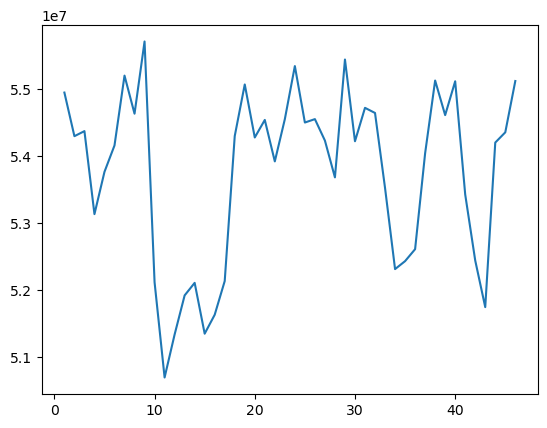

In [8]:
times = np.linspace(1, 46, 46)
print(times)
intensity = results[1600][6]
print(intensity)
plt.plot(times, intensity)
print(type(intensity))

In [9]:
def coefficient_of_variation(intensities: np.ndarray) -> float:
    """
    Computes the coefficient of variation (CV) for a given array of intensity values.

    Parameters:
    intensities (np.ndarray): Array of intensity values.

    Returns:
    float: The coefficient of variation (standard deviation / mean) as a percentage.
    """
    mean_intensity = np.mean(intensities)
    std_intensity = np.std(intensities, ddof=1)  # Use ddof=1 for sample standard deviation
    CV = std_intensity / mean_intensity if mean_intensity != 0 else np.nan  # Avoid division by zero
    return CV*100 # Convert to percentage

# Example usage:
cv = coefficient_of_variation(intensity)
print(f"Coefficient of Variation: {cv:.4f} %")

Coefficient of Variation: 2.4230 %


In [10]:
results = multi_analysis([1300], cal_results, sample_results, 'I')

# Check the results
if results:
    for wl, data in results.items():
        print(f"Wavelength: {wl}")
        print(f"{data[0]}, Mueller matrix of the sample (left).")
        print(f"{data[1]}, Mueller matrix of the sample (right).")
        print(f"Retardance of the sample (left): {data[2]}")
        print(f"Retardance of the sample (right): {data[3]}")
        print(f"Retardance error (left): {data[4]}")
        print(f"Retardance error (right): {data[5]}")
        print(f"{data[6]}, Mueller matrix of the calibration (left).")
        print(f"{data[7]}, Mueller matrix of the calibration (left).")
        print(f"RMS error of the left calibration matrix: {data[8]}")
        print(f"RMS error of the right calibration matrix: {data[9]}")
        print(f"Fit parameters (left) for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer: {data[10]}")
        print(f"Fit parameters (right) for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer: {data[11]}")

else:
    print("No results to display.")

Wavelength: 1300
[[ 1.          0.0006929  -0.00030505 -0.00039326]
 [ 0.00266313  0.99543702  0.08501755  0.00206427]
 [ 0.00153077  0.08542417 -0.99870099 -0.08610659]
 [ 0.00010636 -0.0050707   0.08489771 -0.99524231]], Mueller matrix of the sample (left).
[[ 0.99897119 -0.00069314  0.00030645  0.00039366]
 [ 0.00266829  0.99673264  0.08197823  0.00193138]
 [ 0.00152819  0.08238527 -1.         -0.0861991 ]
 [ 0.00010647 -0.00494282  0.08499367 -0.99627535]], Mueller matrix of the sample (right).
Retardance of the sample (left): 0.4938517994205151
Retardance of the sample (right): 0.5
Retardance error (left): 0.04533064477652567
Retardance error (right): nan
[[ 0.99639534  0.00158635  0.0016503   0.00000847]
 [-0.00155403  1.          0.00272633  0.0013445 ]
 [-0.00139902  0.00242582  0.9988919  -0.00058041]
 [ 0.0000668  -0.00047296  0.00065279  0.9969852 ]], Mueller matrix of the calibration (left).
[[ 0.99906102 -0.00158892 -0.0016478  -0.00000847]
 [-0.0015562   1.          0.002

In [17]:
results_x5_y5 = multi_analysis([1400], cal_results, sample_results_x5_y5, 'I')

# Check the results
if results_x5_y5:
    for wl, data in results_x5_y5.items():
        print(f"Wavelength: {wl}")
        print(f"{data[0]}, Mueller matrix of the sample (left).")
        print(f"{data[1]}, Mueller matrix of the sample (right).")
        print(f"Retardance of the sample (left): {data[2]}")
        print(f"Retardance of the sample (right): {data[3]}")
        print(f"Retardance error (left): {data[4]}")
        print(f"Retardance error (right): {data[5]}")
        print(f"{data[6]}, Mueller matrix of the calibration (left).")
        print(f"{data[7]}, Mueller matrix of the calibration (left).")
        print(f"RMS error of the left calibration matrix: {data[8]}")
        print(f"RMS error of the right calibration matrix: {data[9]}")
        print(f"Fit parameters (left) for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer: {data[10]}")
        print(f"Fit parameters (right) for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer: {data[11]}")

else:
    print("No results to display.")

Wavelength: 1400
[[ 0.98933388  0.01345975  0.00146021  0.02256661]
 [-0.02022375  0.66162202 -0.76614873  0.00099256]
 [ 0.02105632 -0.81313531 -0.62175557 -0.04358616]
 [-0.01892139  0.0346331   0.02048373 -1.        ]], Mueller matrix of the sample (left).
[[ 0.99035082  0.01877758  0.0077107   0.00171354]
 [ 0.0395938   0.58614302 -0.81636609 -0.00417793]
 [-0.02864433 -0.74779913 -0.65589651 -0.0452864 ]
 [ 0.00838591  0.0009427   0.06618176 -1.        ]], Mueller matrix of the sample (right).
Retardance of the sample (left): 0.47271393187310096
Retardance of the sample (right): 0.5
Retardance error (left): 0.18277100822575526
Retardance error (right): nan
[[ 1.         -0.05917564  0.03628908 -0.00990506]
 [ 0.00959491  0.92920474  0.03677384 -0.01083013]
 [ 0.01890227 -0.02069012  0.9470899  -0.01026035]
 [-0.00315427  0.00274878  0.00301389  0.98130343]], Mueller matrix of the calibration (left).
[[ 0.95442428 -0.04327291 -0.02217842 -0.00756752]
 [-0.0121971   0.96739002  0.02

c:\Users\EPL User\Documents\GitHub\wcmelby-HWP_Characterizations\SuperK_Select_Data\JHK_Plate\../../operational_scripts\New_DRRP_Functions.py:438: RuntimeWarning: invalid value encountered in sqrt
  return 2*RMS/np.sqrt(4*x-x**2) # Value in radians


In [35]:
# example usage
results = multi_analysis([1300], cal_results, sample_results, 'I')
matrix1300 = results[1300][0]
calmatrix1300 = results[1300][6]
RMS1300 = results[1300][8]
print(matrix1300)
print(calmatrix1300)
print(RMS1300)

[[ 1.          0.0006929  -0.00030505 -0.00039326]
 [ 0.00266313  0.99543702  0.08501755  0.00206427]
 [ 0.00153077  0.08542417 -0.99870099 -0.08610659]
 [ 0.00010636 -0.0050707   0.08489771 -0.99524231]]
[[ 0.99639534  0.00158635  0.0016503   0.00000847]
 [-0.00155403  1.          0.00272633  0.0013445 ]
 [-0.00139902  0.00242582  0.9988919  -0.00058041]
 [ 0.0000668  -0.00047296  0.00065279  0.9969852 ]]
0.0017507001572879613


c:\Users\EPL User\Documents\GitHub\wcmelby-HWP_Characterizations\SuperK_Select_Data\JHK_Plate\../../operational_scripts\New_DRRP_Functions.py:438: RuntimeWarning: invalid value encountered in sqrt
  return 2*RMS/np.sqrt(4*x-x**2) # Value in radians


In [36]:
# example usage
results = multi_analysis([1300], cal_results, sample_results, 'q')
matrix1300 = results[1300][0]
calmatrix1300 = results[1300][2]
RMS1300 = results[1300][3]
print(matrix1300)
print(calmatrix1300)
print(RMS1300)

[[ 1.         -0.         -0.          0.        ]
 [ 0.00149678  0.97986183 -0.19616838 -0.00958264]
 [ 0.00115056 -0.19633003 -0.98391401 -0.08562799]
 [ 0.00010397  0.00695964  0.08485329 -0.99627053]]
[[ 0.99937049 -0.         -0.          0.        ]
 [ 0.00000454  1.          0.000632    0.00124062]
 [-0.00116561  0.00216019  0.99983406 -0.00076553]
 [ 0.00006623 -0.00037348  0.00071416  0.99862232]]
0.0008487276011290883


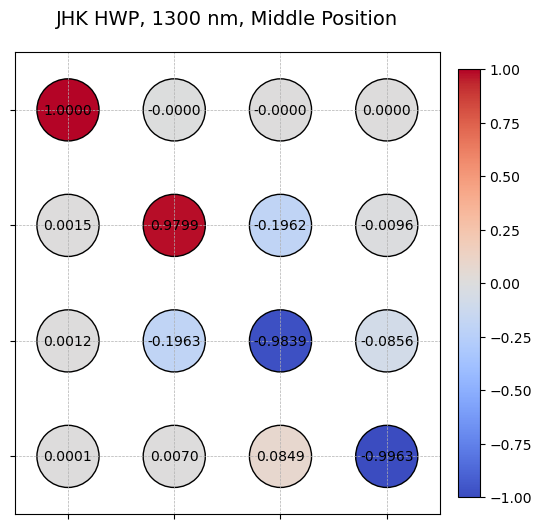

In [ ]:
M = matrix1300  # Use your existing matrix variable

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-0.5, 3.5)
ax.set_ylim(-0.5, 3.5)
ax.set_xticks(range(4))
ax.set_yticks(range(4))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(True, linestyle="--", linewidth=0.5)

# Create scatter plot for the matrix elements
x, y = np.meshgrid(range(4), range(4))
sc = ax.scatter(x, y, c=M, s=2000, cmap="coolwarm", vmin=-1, vmax=1, edgecolors="black")

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
# cbar.set_label("Mueller Matrix Value")

# Annotate values
for i in range(4):
    for j in range(4):
        ax.text(j, i, f"{M[i, j]:.4f}", ha="center", va="center", fontsize=10, color="black")

# Invert y-axis to match matrix order
plt.gca().invert_yaxis()

plt.title("JHK HWP, 1300 nm, Middle Position", fontsize=14, pad=20)
# plt.savefig('JHK_Matrix_1300nm.png', format='png')

plt.show()

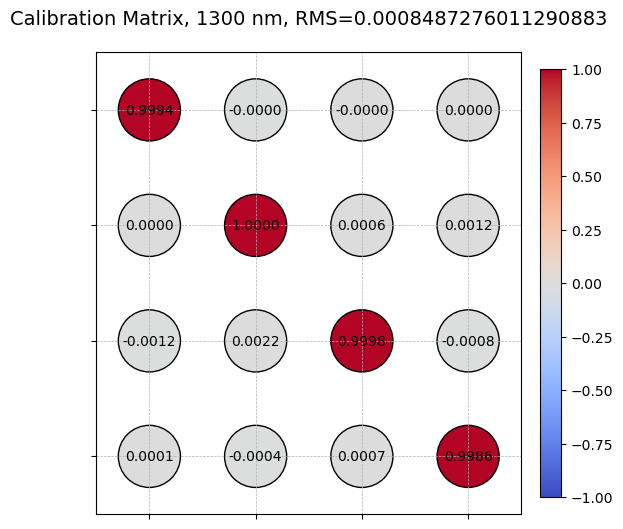

In [38]:
M = calmatrix1300  # Use your existing matrix variable

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-0.5, 3.5)
ax.set_ylim(-0.5, 3.5)
ax.set_xticks(range(4))
ax.set_yticks(range(4))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(True, linestyle="--", linewidth=0.5)

# Create scatter plot for the matrix elements
x, y = np.meshgrid(range(4), range(4))
sc = ax.scatter(x, y, c=M, s=2000, cmap="coolwarm", vmin=-1, vmax=1, edgecolors="black")

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
# cbar.set_label("Mueller Matrix Value")

# Annotate values
for i in range(4):
    for j in range(4):
        ax.text(j, i, f"{M[i, j]:.4f}", ha="center", va="center", fontsize=10, color="black")

# Invert y-axis to match matrix order
plt.gca().invert_yaxis()

plt.title(f"Calibration Matrix, 1300 nm, RMS={RMS1300}", fontsize=14, pad=20)
# plt.savefig('Calibration_Matrix_1300nm.png', format='png')

plt.show()

# Analysis

In [14]:
results = multi_analysis(wavelengths, cal_results, sample_results, 'I')
I_retardance_averages = []
I_RMS_averages = []
Cal_intensities = []
I_retardance_errors_avg = []

for wavelength in wavelengths:
    retardance_avg_value = (results[wavelength][2] + results[wavelength][3])/2
    RMS_avg_value = (results[wavelength][8] + results[wavelength][9])/2

    I_retardance_averages.append(retardance_avg_value)
    I_RMS_averages.append(RMS_avg_value)
    Cal_intensities.append(results[wavelength][12])
    I_retardance_errors_avg.append(results[wavelength][4]+results[wavelength][5])

print(wavelengths)
print(I_retardance_averages)
print(I_RMS_averages)
print(I_retardance_errors_avg) # value in radians

c:\Users\EPL User\Documents\GitHub\wcmelby-HWP_Characterizations\SuperK_Select_Data\JHK_Plate\../../operational_scripts\New_DRRP_Functions.py:398: RuntimeWarning: invalid value encountered in sqrt
  return 2*RMS/np.sqrt(4*x-x**2) # Value in radians


[1100, 1200, 1300, 1400, 1500, 1600, 1750, 1850, 1950]
[0.46698976355066946, 0.4818345316433039, 0.4969258997102576, 0.5, 0.49524908627742475, 0.5, 0.5, 0.5, 0.48404382846543614]
[0.010255525034940049, 0.0039252817750333, 0.0016356280559297125, 0.0015702766593659843, 0.0015159644885795502, 0.0016343415422606466, 0.0016831322768371178, 0.007464457832353695, 0.01972696416057587]
[0.09969786113001176, 0.06899236792364791, nan, nan, nan, nan, nan, nan, 0.39440397395280846]


In [56]:
Cal_CV = [coefficient_of_variation(intensity) for intensity in Cal_intensities]
print(Cal_CV)

[1.2226340475498085, 0.7097843275669986, 1.0380943110586545, 2.3422058110408375, 2.3127112194196298, 2.42297583092854, 0.9291149272818683, 2.9420346021723995, 1.3209307477971635]


In [15]:
results = multi_analysis(wavelengths, cal_results, sample_results, 'q')
Q_retardances = []
Q_RMS_errors = []
Q_retardance_errors = []

for wavelength in wavelengths:
    retardance_value = results[wavelength][1]
    RMS_error = results[wavelength][3]
    
    Q_retardances.append(retardance_value)
    Q_RMS_errors.append(RMS_error)
    Q_retardance_errors.append(results[wavelength][4])

print(Q_retardances)
print(Q_RMS_errors)
print(Q_retardance_errors)

c:\Users\EPL User\Documents\GitHub\wcmelby-HWP_Characterizations\SuperK_Select_Data\JHK_Plate\../../operational_scripts\New_DRRP_Functions.py:398: RuntimeWarning: invalid value encountered in sqrt
  return 2*RMS/np.sqrt(4*x-x**2) # Value in radians


[0.46718401903781925, 0.4803980606070216, 0.5, 0.4954119535915603, 0.49314154597764465, 0.5, 0.5, 0.49187835811000863, 0.4818261129282001]
[0.009521105656635765, 0.003397658160913984, 0.0008487276011290883, 0.0012501562784952948, 0.0011618328979858233, 0.0009037758589933233, 0.001072866414633527, 0.004471888298972934, 0.01939005986902231]
[0.04650543955003201, 0.027656632483006496, nan, 0.04337273304794049, 0.026969443943499507, nan, nan, 0.08767095664394421, 0.1701749710977963]


In [16]:
0.170/(2*np.pi)

0.02705634032562221

In [58]:
results_x5_y5 = multi_analysis(wavelengths, cal_results, sample_results_x5_y5, 'I')
I_retardance_averages_x5_y5 = []
I_RMS_averages_x5_y5 = []

for wavelength in wavelengths:
    retardance_avg_value = (results_x5_y5[wavelength][2] + results_x5_y5[wavelength][3])/2
    RMS_avg_value = (results_x5_y5[wavelength][8] + results_x5_y5[wavelength][9])/2

    I_retardance_averages_x5_y5.append(retardance_avg_value)
    I_RMS_averages_x5_y5.append(RMS_avg_value)

print(I_retardance_averages_x5_y5)

[0.4661472164453214, 0.48309056729223226, 0.4980581167365471, 0.5, 0.495604607142184, 0.49828314048456124, 0.5, 0.5, 0.5]


In [59]:
results = multi_analysis(wavelengths, cal_results, sample_results_x5_y5, 'q')
Q_retardances_x5_y5 = []
Q_RMS_errors_x5_y5 = []

for wavelength in wavelengths:
    retardance_value = results[wavelength][1]
    RMS_error = results[wavelength][3]
    
    Q_retardances_x5_y5.append(retardance_value)
    Q_RMS_errors_x5_y5.append(RMS_error)

print(Q_retardances_x5_y5)

[0.46770690780275903, 0.4809702820165978, 0.4943064140185003, 0.49615030369413626, 0.4896683514882425, 0.49628549353642987, 0.5, 0.4892242115725041, 0.5]


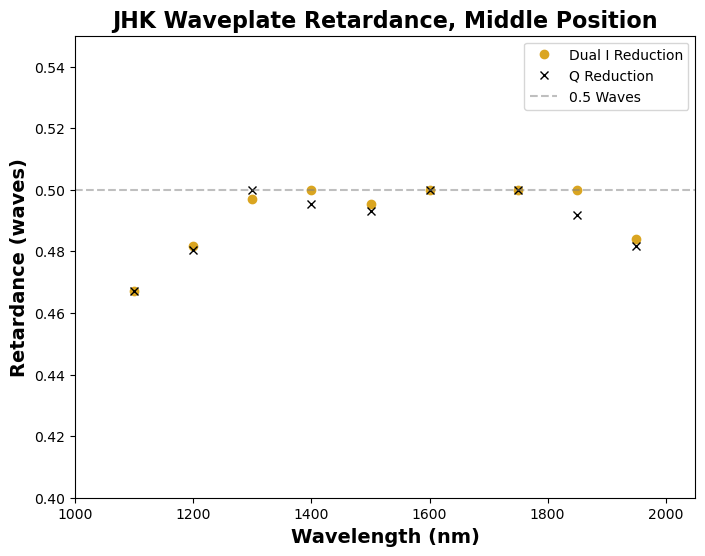

In [60]:
plt.figure(figsize=(8, 6))
plt.plot(wavelengths, I_retardance_averages, 'o', color='goldenrod', label='Dual I Reduction')
# plt.plot(wavelengths, I_retardance_averages_x5_y5, '^', color='k', label='x_5 y_5 Positon, Dual I Inversion')
plt.plot(wavelengths, Q_retardances, 'x', color='k', label='Q Reduction')
# plt.plot(wavelengths, Q_retardances_x5_y5, 'x', color='k', label='x_5 y_5 Positon Positon, Q Inversion')
plt.axhline(y=0.5, color='grey', linestyle='--', alpha=0.5, label='0.5 Waves')
plt.xlabel('Wavelength (nm)', fontweight='bold', fontsize=14)
plt.ylabel('Retardance (waves)', fontweight='bold', fontsize=14)
plt.xlim([1000, 2050])
plt.ylim([0.4, 0.55])
plt.title('JHK Waveplate Retardance, Middle Position', fontweight='bold', fontsize=16)
plt.legend()
# plt.savefig('JHK_Retardance_I.png', format='png')
plt.show()

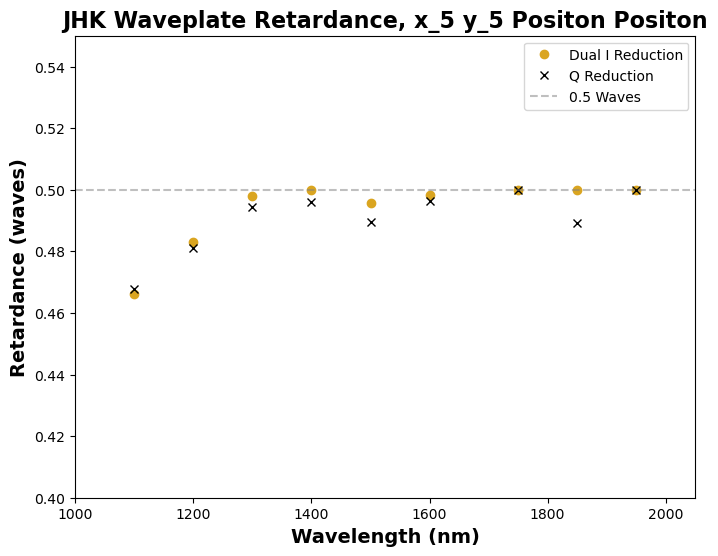

In [61]:
plt.figure(figsize=(8, 6))
# plt.plot(wavelengths, I_retardance_averages, '^', color='orangered', label='Middle Positon, Dual I Inversion')
plt.plot(wavelengths, I_retardance_averages_x5_y5, 'o', color='goldenrod', label='Dual I Reduction')
# plt.plot(wavelengths, Q_retardances, 'x', color='orangered', label='Middle Positon, Q Inversion')
plt.plot(wavelengths, Q_retardances_x5_y5, 'x', color='k', label='Q Reduction')
plt.axhline(y=0.5, color='grey', linestyle='--', alpha=0.5, label='0.5 Waves')
plt.xlabel('Wavelength (nm)', fontweight='bold', fontsize=14)
plt.ylabel('Retardance (waves)', fontweight='bold', fontsize=14)
plt.xlim([1000, 2050])
plt.ylim([0.4, 0.55])
plt.title('JHK Waveplate Retardance, x_5 y_5 Positon Positon', fontweight='bold', fontsize=16)
plt.legend()
# plt.savefig('JHK_Retardance_I.png', format='png')
plt.show()

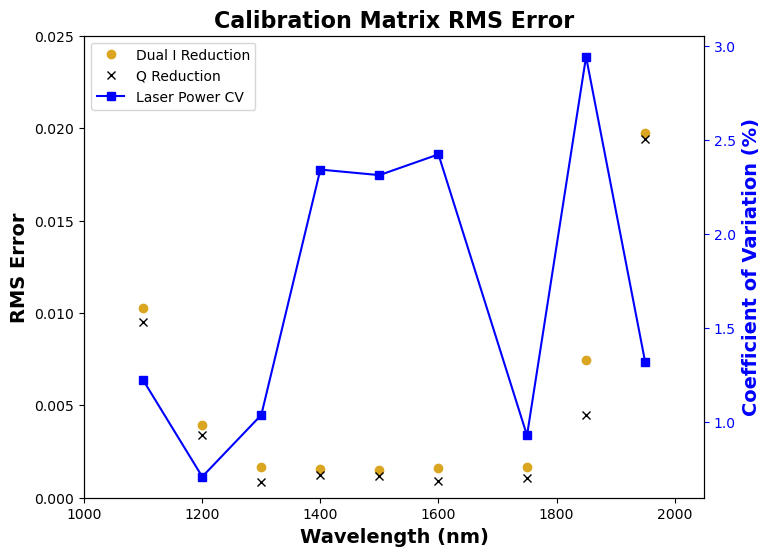

In [62]:
fig, ax1 = plt.subplots(figsize=(8, 6))

# Primary axis (Left Y-axis)
p1, = ax1.plot(wavelengths, I_RMS_averages, 'o', color='goldenrod', label='Dual I Reduction')
p2, = ax1.plot(wavelengths, Q_RMS_errors, 'x', color='k', label='Q Reduction')

ax1.set_xlabel('Wavelength (nm)', fontweight='bold', fontsize=14)
ax1.set_ylabel('RMS Error', fontweight='bold', fontsize=14)
ax1.set_xlim([1000, 2050])
ax1.set_ylim([0, 0.025])
ax1.set_title('Calibration Matrix RMS Error', fontweight='bold', fontsize=16)

# Secondary axis (Right Y-axis for CV values)
ax2 = ax1.twinx()
p3, = ax2.plot(wavelengths, Cal_CV, 's-', color='b', label='Laser Power CV')
ax2.set_ylabel('Coefficient of Variation (%)', fontweight='bold', fontsize=14, color='blue')
ax2.tick_params(axis='y', colors='blue')

# Combine all legend handles and labels into one legend on ax1
handles = [p1, p2, p3]
labels = [h.get_label() for h in handles]
ax1.legend(handles, labels, loc='upper left')

plt.show()

In [63]:
print(I_RMS_averages)
print(Q_RMS_errors)

[0.010255525034940049, 0.0039252817750333, 0.0016356280559297125, 0.0015702766593659843, 0.0015159644885795502, 0.0016343415422606466, 0.0016831322768371178, 0.007464457832353695, 0.01972696416057587]
[0.009521105656635765, 0.003397658160913984, 0.0008487276011290883, 0.0012501562784952948, 0.0011618328979858233, 0.0009037758589933233, 0.001072866414633527, 0.004471888298972934, 0.01939005986902231]


**Dodge for MgF2 (magnesium fluoride), Ghosh for SiO2 (quartz)** <br>
ne for extraordinary refractive index, no for ordinary refractive index

In [5]:
MgF2_ne = np.loadtxt("../Dodge-e.csv", delimiter=",",skiprows=1)
MgF2_no = np.loadtxt("../Dodge-o.csv", delimiter=",",skiprows=1)
SiO2_ne = np.loadtxt("../Ghosh-e.csv", delimiter=",",skiprows=1)
SiO2_no = np.loadtxt("../Ghosh-o.csv", delimiter=",",skiprows=1)

In [49]:
print(np.mean(MgF2_ne[:,1] - MgF2_no[:,1]))
print(np.mean(SiO2_ne[:,1] - SiO2_no[:,1]))

0.01111017577824357
0.008902925743215842


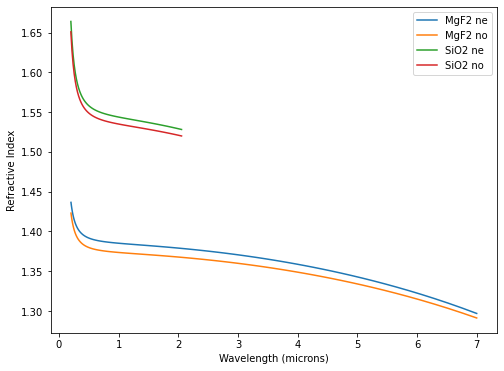

In [51]:
# looks good, index of refraction for materials
plt.figure(figsize=(8, 6))
plt.plot(MgF2_ne[:,0], MgF2_ne[:,1], label="MgF2 ne")
plt.plot(MgF2_no[:,0], MgF2_no[:,1], label="MgF2 no")
plt.plot(SiO2_ne[:,0], SiO2_ne[:,1], label="SiO2 ne")
plt.plot(SiO2_no[:,0], SiO2_no[:,1], label="SiO2 no")
plt.xlabel("Wavelength (microns)")
plt.ylabel("Refractive Index")
plt.legend()

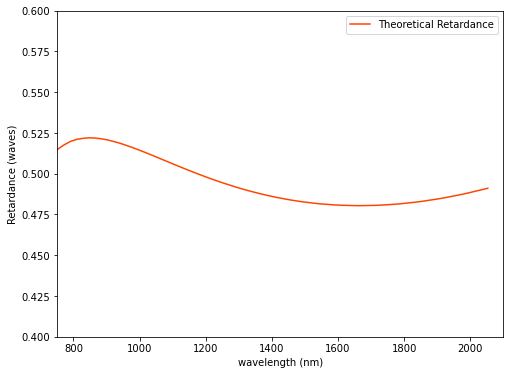

In [44]:
def theoretical_plot(d1, d2, MgF2_ne, MgF2_no, SiO2_ne, SiO2_no):
    """
    Computes the retardance of a waveplate made of MgF2 and Quartz.
    Returns wavelengths and predicted retardance.
    """
    w = SiO2_ne[:, 0]  # Use the Quartz wavelengths as reference grid. Wavelengths in microns, from roughly 0.2 to 2

    MgF2_ne_interp = np.interp(w, MgF2_ne[:, 0], MgF2_ne[:, 1])
    MgF2_no_interp = np.interp(w, MgF2_no[:, 0], MgF2_no[:, 1])
    # SiO2_ne_interp = np.interp(w, SiO2_ne[:, 0], SiO2_ne[:, 1])
    # SiO2_no_interp = np.interp(w, SiO2_no[:, 0], SiO2_no[:, 1])
    SiO2_ne_interp = SiO2_ne[:, 1]
    SiO2_no_interp = SiO2_no[:, 1]
    
    # Calculate birefringence
    delta_mgf2 = MgF2_ne_interp - MgF2_no_interp
    delta_quartz = -(SiO2_ne_interp - SiO2_no_interp)  # Negative due to 90° rotation

    # Compute the retardance in waves
    predicted_retardance = (1 / w) * (delta_mgf2 * d1 + delta_quartz * d2)

    # convert wavelength from microns to nm
    return w*1000, predicted_retardance

theoretical_data = theoretical_plot(1226, 1564, MgF2_ne, MgF2_no, SiO2_ne, SiO2_no)
plt.figure(figsize=(8, 6))
plt.plot(theoretical_data[0], theoretical_data[1], '-', color='orangered', label='Theoretical Retardance')
plt.xlim([750, 2100])
plt.ylim([0.4, 0.6])
plt.xlabel('wavelength (nm)')
plt.ylabel('Retardance (waves)')
plt.legend()
plt.show()

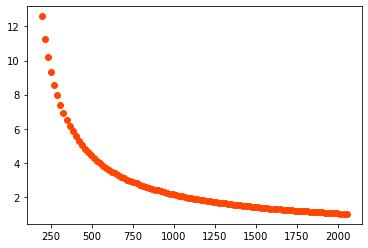

In [45]:
# looks good, just mag fluoride zeroth order waveplate

def mgf2_theoretical_plot(d1, d2, MgF2_ne, MgF2_no, SiO2_ne, SiO2_no):
    """
    Computes the retardance of a waveplate made of MgF2 and Quartz.
    Returns wavelengths and predicted retardance.
    """
    w = SiO2_ne[:, 0]  # Use the Quartz wavelengths as reference grid. Wavelengths in microns, from roughly 0.2 to 2

    MgF2_ne_interp = np.interp(w, MgF2_ne[:, 0], MgF2_ne[:, 1])
    MgF2_no_interp = np.interp(w, MgF2_no[:, 0], MgF2_no[:, 1])
    # SiO2_ne_interp = np.interp(w, SiO2_ne[:, 0], SiO2_ne[:, 1])
    # SiO2_no_interp = np.interp(w, SiO2_no[:, 0], SiO2_no[:, 1])
    SiO2_ne_interp = SiO2_ne[:, 1]
    SiO2_no_interp = SiO2_no[:, 1]
    
    # Calculate birefringence
    delta_mgf2 = MgF2_ne_interp - MgF2_no_interp
    delta_quartz = -(SiO2_ne_interp - SiO2_no_interp)  # Negative due to 90° rotation

    # Compute the retardance in waves
    predicted_retardance = (1 / w) * (delta_mgf2 * d1) # + delta_quartz * d2)

    # convert wavelength from microns to nm
    return w*1000, predicted_retardance

mgf2_theoretical_data = mgf2_theoretical_plot(185, 1550, MgF2_ne, MgF2_no, SiO2_ne, SiO2_no)
plt.plot(mgf2_theoretical_data[0], mgf2_theoretical_data[1], 'o', color='orangered', label='Theoretical Retardance')

In [6]:
def predicted_retardance(d1, d2, MgF2_ne, MgF2_no, SiO2_ne, SiO2_no):
    """
    Computes the retardance of a waveplate made of MgF2 and Quartz.
    Returns wavelengths and predicted retardance.
    """
    w = SiO2_ne[:, 0]  # Use the Quartz wavelengths as reference grid

    MgF2_ne_interp = np.interp(w, MgF2_ne[:, 0], MgF2_ne[:, 1])
    MgF2_no_interp = np.interp(w, MgF2_no[:, 0], MgF2_no[:, 1])
    SiO2_ne_interp = np.interp(w, SiO2_ne[:, 0], SiO2_ne[:, 1])
    SiO2_no_interp = np.interp(w, SiO2_no[:, 0], SiO2_no[:, 1])
    
    # Calculate birefringence
    delta_mgf2 = MgF2_ne_interp - MgF2_no_interp
    delta_quartz = -(SiO2_ne_interp - SiO2_no_interp)  # Negative due to 90° rotation

    # Compute the retardance in waves
    predicted_retardance = (1 / w) * (delta_mgf2 * d1 + delta_quartz * d2)

    # convert wavelength from microns to nm, and constrain retardance from 0 to 0.5 waves
    return w*1000, predicted_retardance%0.5

In [7]:
def fit_function(wavelengths, d1, d2):
    w, pred_retardance = predicted_retardance(d1, d2, MgF2_ne, MgF2_no, SiO2_ne, SiO2_no)
    return np.interp(wavelengths, w, pred_retardance)

In [126]:
opt_params, cov_matrix = curve_fit(fit_function, wavelengths, Q_retardances, p0=[1000, 1000])
print(opt_params)

[118164.4165227  162295.57890461]


c:\Users\EPL User\.conda\envs\First_Light_SDK\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[2128.30142971 2470.08267593]


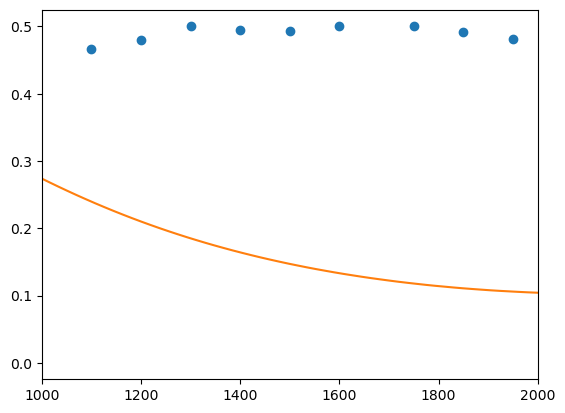

In [134]:
opt_params, cov_matrix = curve_fit(fit_function, wavelengths, Q_retardances, p0=[1000, 1000])
print(opt_params)
# w, prediction = predicted_retardance(opt_params[0], opt_params[1], MgF2_ne, MgF2_no, SiO2_ne, SiO2_no)
w, prediction = predicted_retardance(1200, 1500, MgF2_ne, MgF2_no, SiO2_ne, SiO2_no)


plt.plot(wavelengths, Q_retardances, 'o', label='Measured Retardance')
plt.xlim([1000, 2000])
# plt.ylim([0, 1])
plt.plot(w, prediction, label='Predicted Retardance')